In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model
from transform import TensorAugment, ResizeBlur
from models import WDMClassifierMedium, WDMClassifierLarge
from sklearn.metrics import accuracy_score

In [3]:
cdm_model='IllustrisTNG'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'

# Sample indices
all_indices = range(15000)



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WDMClassifierLarge().to(device)
checkpoint = torch.load("best_cnn_model_blur_(0.0, 0.0)_large.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

WDMClassifierLarge(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 

In [6]:
# Model trained on IllustrisTNG normalisation, eval needs to be normalised the same

cdm_file='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mstar_IllustrisTNG_WDM_z=0.00.npy'
    
cdm = np.log1p(np.load(cdm_file))
wdm = np.log1p(np.load(wdm_file))
total = np.concatenate((cdm,wdm),axis=0)
mean,std = total.mean(), total.std()

data_stats = {
    'mean': mean,
    'std': std
}
print(f'Normalising with mean: {data_stats['mean']:.3f}, std: {data_stats['std']:.3f}')

Normalising with mean: 0.282, std: 2.518


In [55]:
import numpy as np
import Pk_library as PKL

# parameters
BoxSize = 25.0     #Mpc/h
MAS     = 'None'  #MAS used to create the delta; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads

cdm_sample = np.load(cdm_file)
# create an empty delta
img = np.log1p(cdm_sample[0])
delta = img - img.mean()

# compute the Pk of that delta
Pk2D = PKL.Pk_plane(delta, BoxSize, MAS, threads)

# get the attributes of the routine
k      = Pk2D.k      #k in h/Mpc
Pk     = Pk2D.Pk     #Pk in (Mpc/h)^2
Nmodes = Pk2D.Nmodes #Number of modes in the different k bins


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.47 seconds


Lowest frequency: 0.30337902366992636
Highest frequency: 45.49512128674168


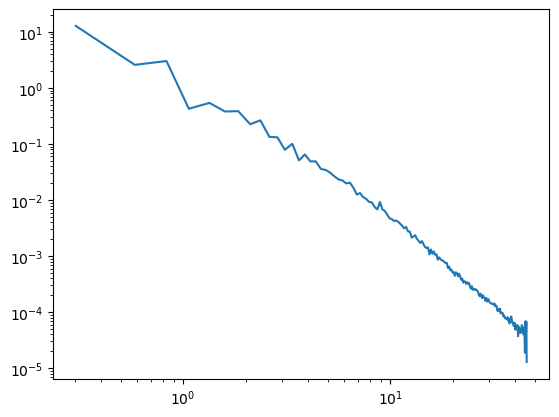

In [56]:
import matplotlib.pyplot as plt
print('Lowest frequency:',np.min(k))
print('Highest frequency:',np.max(k))
plt.loglog(k,Pk)
plt.show()


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


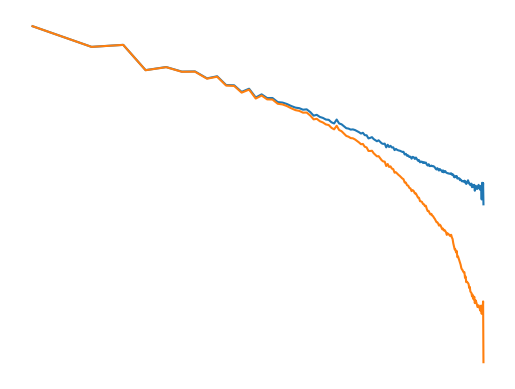

In [66]:
from scipy.ndimage import gaussian_filter
delta_smoothed = gaussian_filter(delta,sigma=0.8,radius=3)
Pk2D_smoothed = PKL.Pk_plane(delta_smoothed, BoxSize, MAS, threads)
k_smoothed      = Pk2D_smoothed.k      #k in h/Mpc
Pk_smoothed     = Pk2D_smoothed.Pk     #Pk in (Mpc/h)^2
plt.loglog(k,Pk)
plt.loglog(k_smoothed,Pk_smoothed)
plt.axis('off')
plt.savefig('pk.png')
plt.show()

In [1]:
import numpy as np

In [7]:
cdm_file='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mstar_IllustrisTNG_WDM_z=0.00.npy'


cdm = np.log1p(np.load(cdm_file))
wdm = np.log1p(np.load(wdm_file))
total = np.concatenate((cdm,wdm),axis=0)
mean = total.mean()
std = total.std()

data_stats = {
    'mean': mean,
    'std': std
}

print(f'Normalising with mean: {data_stats['mean']:.3f}, std: {data_stats['std']:.3f}')

Normalising with mean: 0.282, std: 2.518


In [8]:
masses = []
with open('/n/netscratch/iaifi_lab/Lab/msliu/WDM_masses.txt','r') as f:
    for line in f.readlines()[1:]:
        _,_,_,_,_,m = line.strip().split(' ')
        m = float(m)
        masses.append(m)

masses = np.asarray(masses)

In [34]:
from tqdm import tqdm
cdm_model='Astrid'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mstar_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mstar_IllustrisTNG_WDM_z=0.00.npy'

# Sample indices
all_indices = range(15000)

# --- Define transform for this sigma ---
blur_transform = TensorAugment(
    size=(256, 256),
    p_flip=0.0,
    p_rot=0.0,
    noise_std=0,
    blur_kernel=0,
    blur_sigma=None,
    apply_log=True,
    normalize_stats=data_stats
)

# --- Dataset and loader ---
test_dataset = load_dataset(all_indices, transform=blur_transform, cdm_file=cdm_file, wdm_file=wdm_file)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, 
                         num_workers=1, pin_memory=True)

from sklearn.metrics import accuracy_score

acc = []  

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, sigma_batch, y = batch
        x = x.to(device)
        sigma_batch = sigma_batch.to(device)
        y = y.to(device)

        # Forward through model
        logits = model(x, sigma_batch).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        # Accuracy for this batch
        batch_acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
        acc.append(batch_acc)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/Astrid/Maps_Mstar_Astrid_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mstar_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 30000 samples


100%|████████████████████████████████████████████████████████████████| 938/938 [01:19<00:00, 11.74it/s]


In [35]:
for a in acc:
    with open('acc_per_batch_32.txt', 'a') as file:
        file.write(f'{cdm_model} {a:.6f}\n')

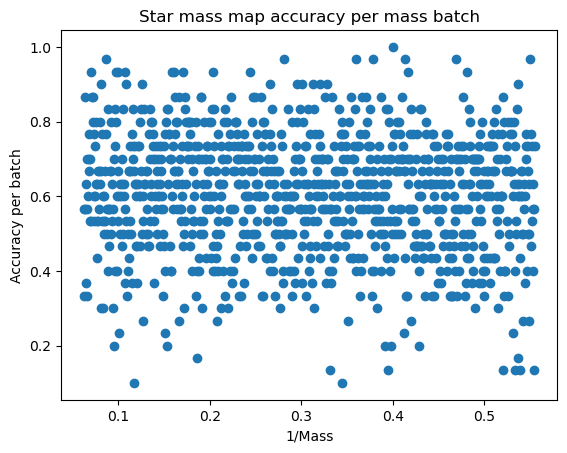

In [25]:
# Run evaluation of batch size 30 before running this
# or load accuracy from acc_per_mass_batch.txt

# --- Load data ---
acc = []
with open('acc_per_mass_batch.txt', 'r') as f:
    for line in f:
        _,a = line.strip().split(' ')
        acc.append(float(a))

acc = np.asarray(acc)

masses=[]

with open('/n/netscratch/iaifi_lab/Lab/msliu/WDM_masses.txt','r') as f:
    for line in f.readlines()[1:]:
        _,_,_,_,_,m = line.strip().split(' ')
        masses.append(float(m))

masses = np.asarray(masses)
masses = masses[:len(acc)]
acc = np.asarray(acc)

plt.scatter(masses,acc)
plt.title('Star mass map accuracy per mass batch')
plt.xlabel('1/Mass')
plt.ylabel('Accuracy per batch')
plt.savefig('acc_vs_mass.png')

In [22]:
from scipy.stats import binned_statistic

bin_means, bin_edges, binnum = binned_statistic(masses, acc, statistic='mean',bins=32)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
bin_std, _, _ = binned_statistic(masses, acc, statistic='std',bins=32)

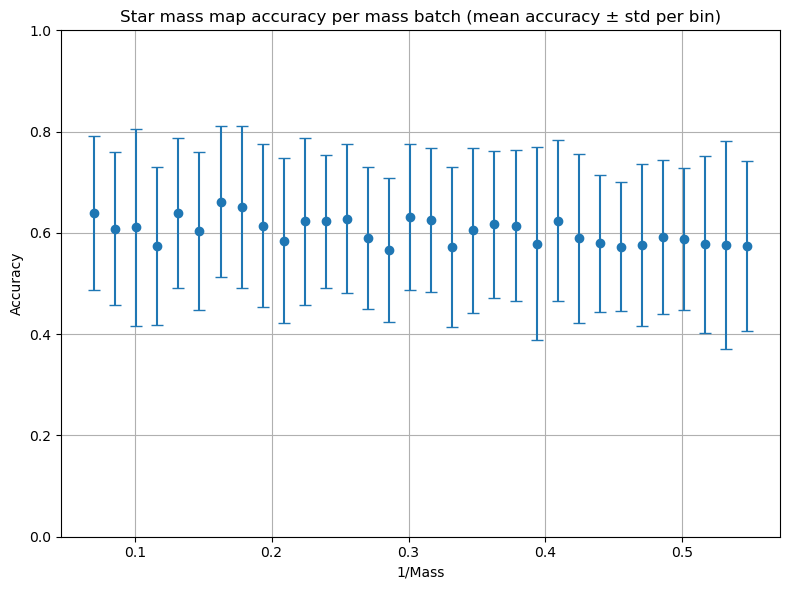

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute bin centers ---
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # average of left and right edges

# --- Plot mean ± std with optional size encoding ---
plt.figure(figsize=(8, 6))
plt.errorbar(
    bin_centers,
    bin_means,
    yerr=bin_std,
    fmt='o',
    capsize=4
)

# Optional: Size of points proportional to number of samples in bin
# plt.scatter(bin_centers, mean, s=binnum*2, alpha=0.6)

plt.xlabel('1/Mass')
plt.ylabel('Accuracy')
plt.title('Star mass map accuracy per mass batch (mean accuracy ± std per bin)')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.tight_layout()
plt.savefig('hist_std.png')
plt.show()


<Figure size 800x600 with 0 Axes>

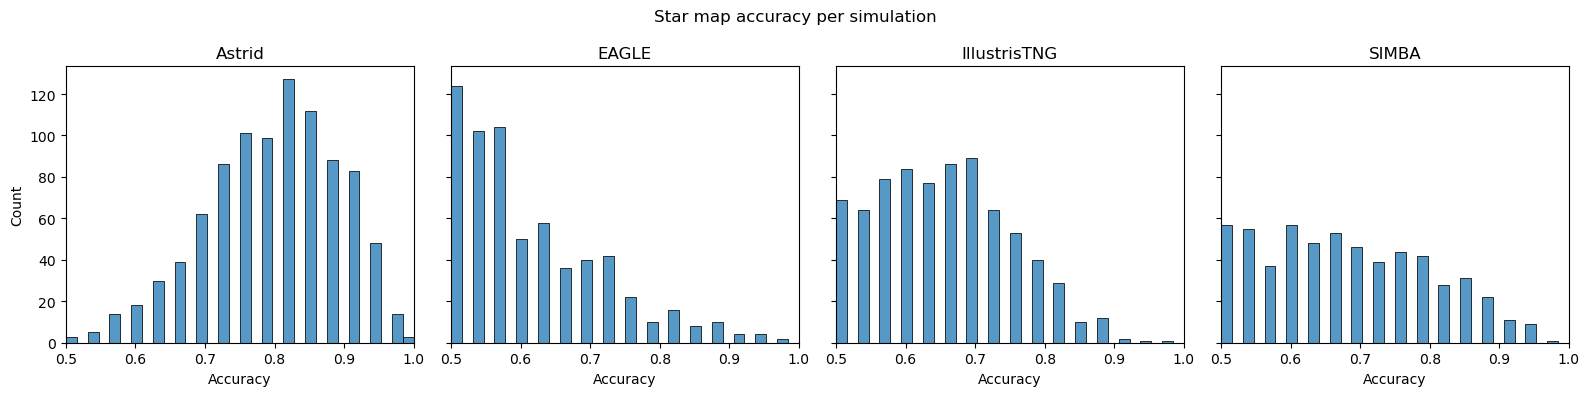

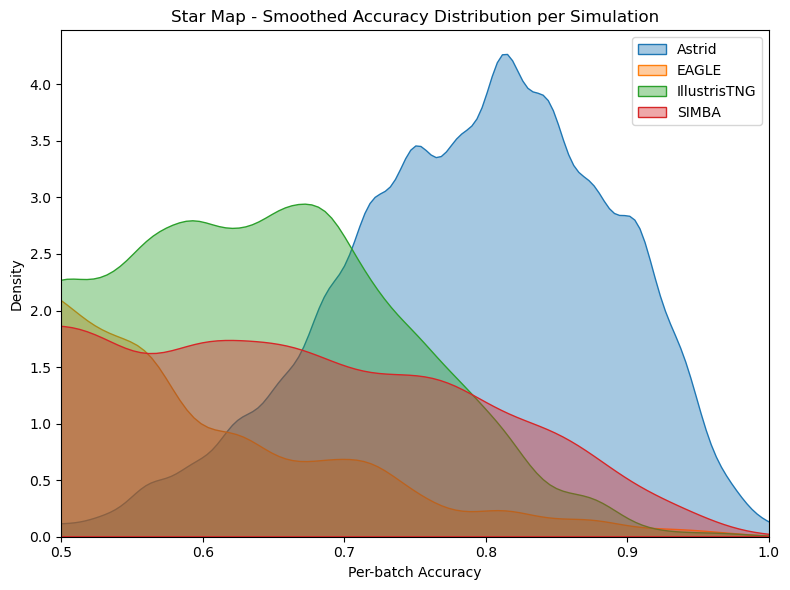

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
data = []
with open('acc_per_batch_32.txt', 'r') as f:
    for line in f:
        data.append(line.strip().split(' '))

data = np.asarray(data)

# --- Plot setup ---
plt.figure(figsize=(8, 6))

sims = np.unique(data[:, 0])
fig, axes = plt.subplots(1, len(sims), figsize=(16, 4), sharey=True)

bins = np.linspace(0.5, 1.0, 33)

for ax, sim in zip(axes, sims):
    acc = data[data[:, 0] == sim][:, 1].astype(float)
    sns.histplot(acc, bins=bins, kde=False, ax=ax, color='tab:blue')
    ax.set_title(sim)
    ax.set_xlim(0.5, 1)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Count')

fig.suptitle('Star map accuracy per simulation')

plt.tight_layout()
plt.savefig('hist.png')
plt.show()

plt.figure(figsize=(8, 6))

for sim in np.unique(data[:, 0]):
    acc = data[data[:, 0] == sim][:, 1].astype(float)
    sns.kdeplot(acc, label=sim, fill=True, common_norm=False, alpha=0.4, bw_adjust=0.6)

plt.xlim(0.5, 1)
plt.xlabel('Per-batch Accuracy')
plt.ylabel('Density')
plt.title('Star Map - Smoothed Accuracy Distribution per Simulation')
plt.legend()
plt.tight_layout()
plt.savefig('smoothed_hist.png')
plt.show()



tensor([[0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1.]])


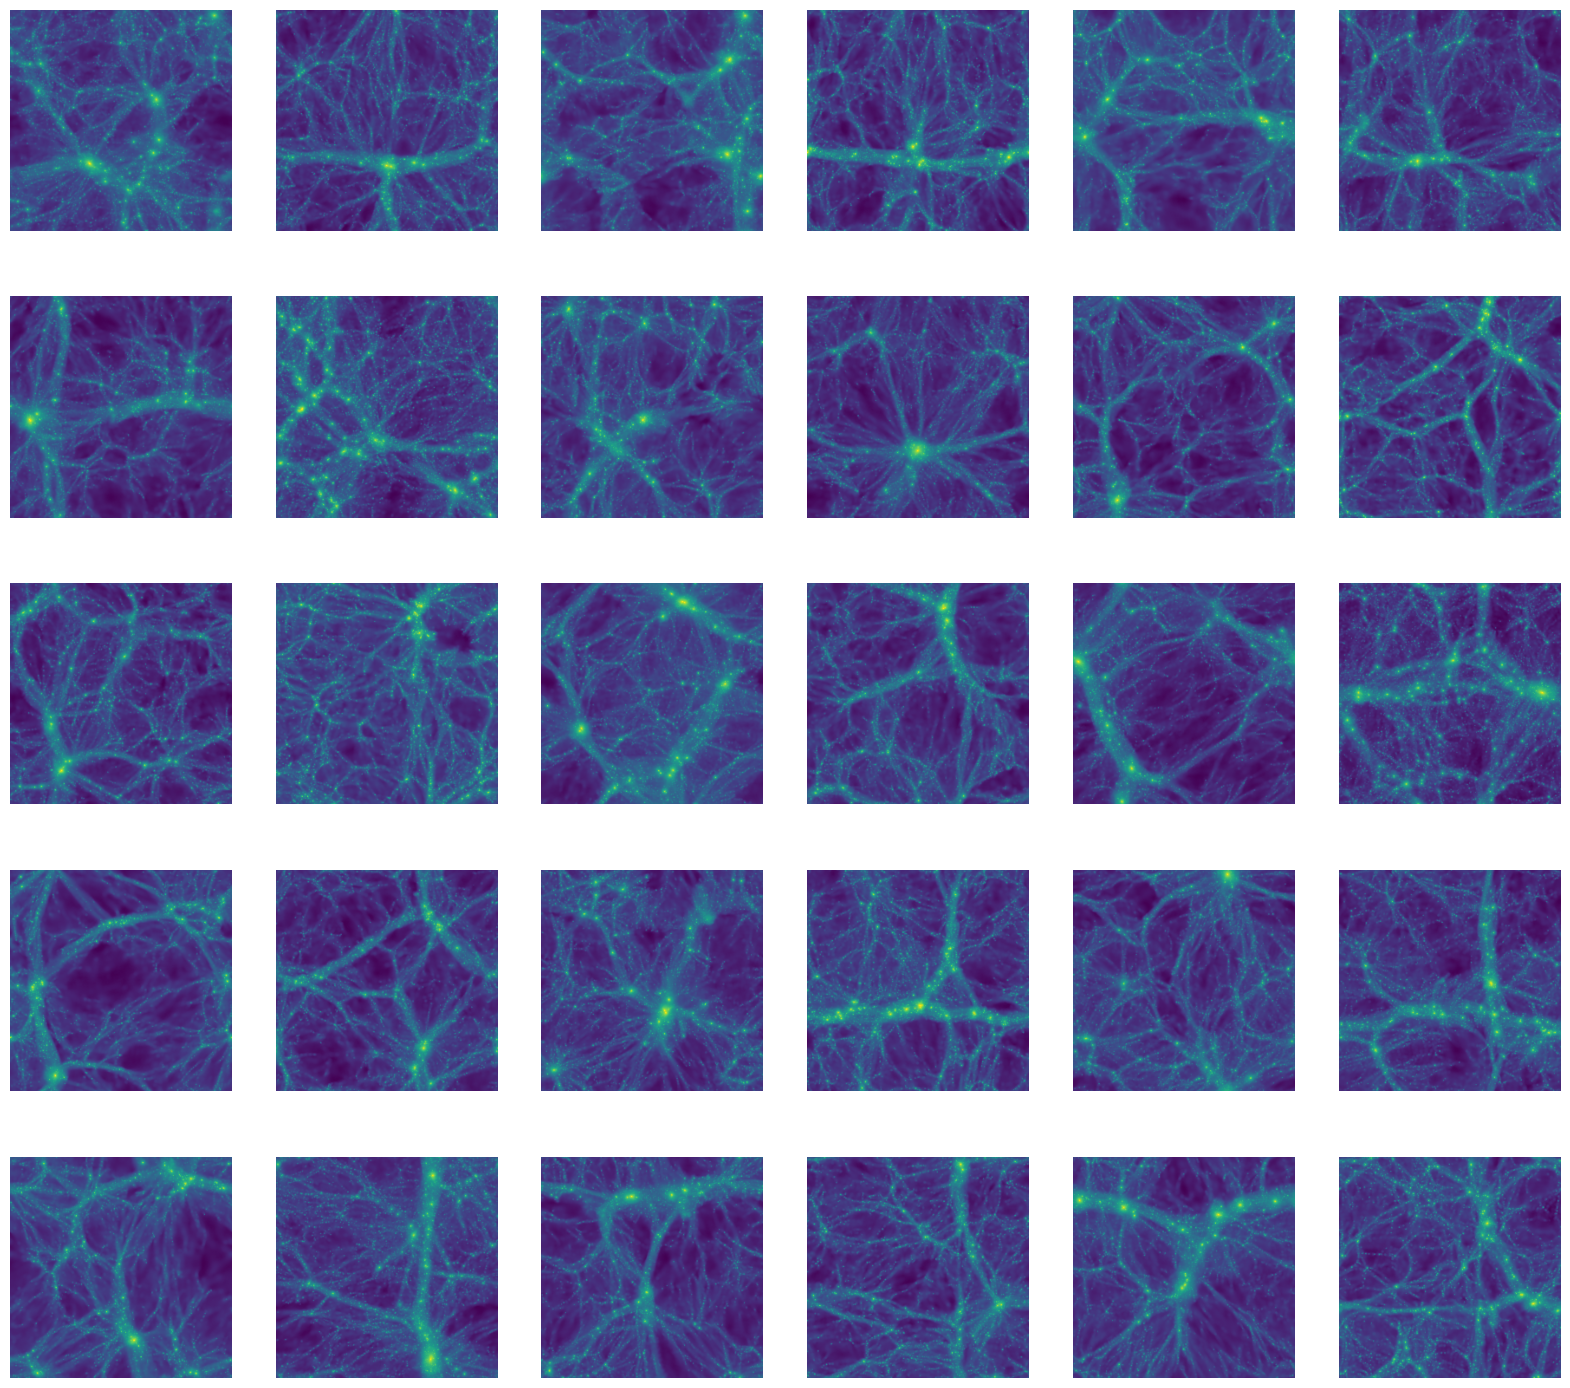

In [65]:
print(lbls.reshape(5,6))

plt.figure(figsize=(20,18))
for idx, img in enumerate(imgs):
    plt.subplot(5,6,idx+1)
    plt.imshow(img[0])
    plt.axis('off')
plt.show()
